In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

import warnings
warnings.filterwarnings('ignore')

In [8]:
balanced_df = pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
imbalanced_df = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv')
multiclass_df = pd.read_csv('diabetes copy.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

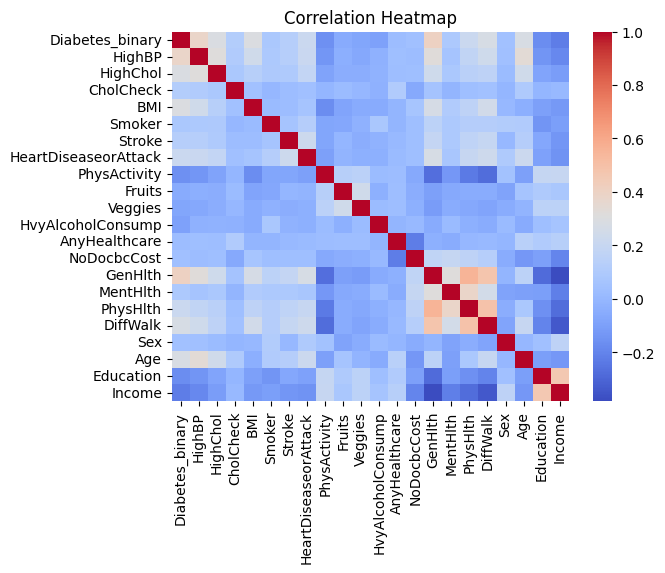

In [9]:
print(balanced_df.info())
print(balanced_df.describe())
print("Missing values:\n", balanced_df.isnull().sum())
print("Class balance:\n", balanced_df['Diabetes_binary'].value_counts(normalize=True))

sns.heatmap(balanced_df.corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [4]:
X = balanced_df.drop('Diabetes_binary', axis=1)
y = balanced_df['Diabetes_binary']
logreg = LogisticRegression(max_iter=1000)
rfe = RFE(logreg, n_features_to_select=10)
rfe.fit(X, y)
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features.tolist())

Selected features: ['HighBP', 'HighChol', 'CholCheck', 'Stroke', 'HeartDiseaseorAttack', 'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'Sex', 'Age']


In [10]:
X = balanced_df.drop(columns='Diabetes_binary')
y = balanced_df['Diabetes_binary']

# 1. Mutual Information (entropy-based)
mi = mutual_info_classif(X, y, discrete_features='auto')
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Mutual Information Scores:\n", mi_series)

# 2. Recursive Feature Elimination
rfe_selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=10)
rfe_selector.fit(X, y)
selected_features = X.columns[rfe_selector.support_]
print("RFE Selected Features:", selected_features.tolist())

Mutual Information Scores:
 GenHlth                 0.092105
HighBP                  0.080203
BMI                     0.057589
HighChol                0.047224
Age                     0.046323
DiffWalk                0.040310
Income                  0.027277
PhysHlth                0.025361
HeartDiseaseorAttack    0.022481
PhysActivity            0.019430
Education               0.019173
CholCheck               0.013272
Veggies                 0.010532
Stroke                  0.009706
Smoker                  0.009215
Fruits                  0.007498
AnyHealthcare           0.006087
Sex                     0.005771
MentHlth                0.004919
HvyAlcoholConsump       0.003587
NoDocbcCost             0.000000
dtype: float64
RFE Selected Features: ['HighBP', 'HighChol', 'CholCheck', 'Stroke', 'HeartDiseaseorAttack', 'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'Sex', 'Age']


## Phase 3: Model Training and Cross-Validation

In [11]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(kernel='rbf', probability=True)
}

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Logistic Regression CV Accuracy: 0.7477
Logistic Regression Test Metrics:
Accuracy: 0.7485854394568088
Precision: 0.7376487558600794
Recall: 0.7715956242927198
F1 Score: 0.7542404129793511

Decision Tree CV Accuracy: 0.6526
Decision Tree Test Metrics:
Accuracy: 0.656308940022633
Precision: 0.6577820085673489
Recall: 0.6516408902301019
F1 Score: 0.6546970486522337

Random Forest CV Accuracy: 0.7372
Random Forest Test Metrics:
Accuracy: 0.7354300264051301
Precision: 0.7183209444687363
Recall: 0.7746133534515277
F1 Score: 0.7454058714097735

SVM CV Accuracy: 0.7479
SVM Test Metrics:
Accuracy: 0.7474537910222557
Precision: 0.7204301075268817
Recall: 0.8087514145605432
F1 Score: 0.7620401634974231


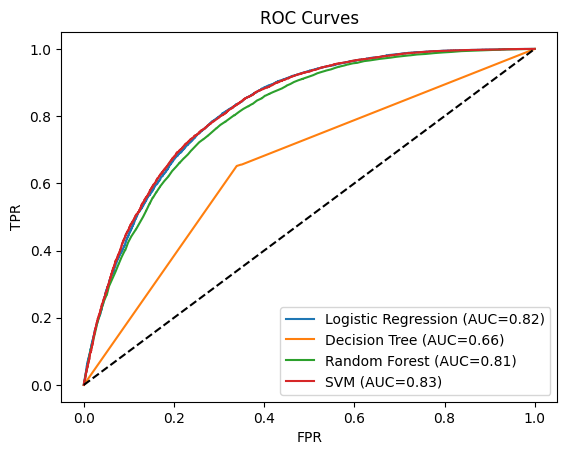

In [12]:
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"\n{name} CV Accuracy: {scores.mean():.4f}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Test Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(X_test)[:, 1]
    else:
        probs = model.decision_function(X_test)

    auc = roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [13]:
## hyperparam tuning
from sklearn.model_selection import GridSearchCV

# log regression
print("\n logistic regression")
log_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}
log_grid = GridSearchCV(LogisticRegression(max_iter=1000), log_params, cv=5, scoring='f1', n_jobs=-1)
log_grid.fit(X_train, y_train)
best_log = log_grid.best_estimator_
print("est Logistic Regression Params:", log_grid.best_params_)

#decision tree
print("\n decision tree")
tree_params = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, scoring='f1', n_jobs=-1)
tree_grid.fit(X_train, y_train)
best_tree = tree_grid.best_estimator_
print("Best Decision Tree Params:", tree_grid.best_params_)

# random forest
print("\n random forest")
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
print("Best Random Forest Params:", rf_grid.best_params_)



 logistic regression
est Logistic Regression Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

 decision tree
Best Decision Tree Params: {'max_depth': 5, 'min_samples_split': 2}

 random forest
Best Random Forest Params: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 200}

 svm


KeyboardInterrupt: 

In [14]:
# svm
from sklearn.model_selection import RandomizedSearchCV

X_tune, _, y_tune, _ = train_test_split(X_train, y_train, train_size=5000, stratify=y_train, random_state=42)

svm_params = {
    'C': [0.1, 1, 10, 50],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

svm_rand = RandomizedSearchCV(
    SVC(probability=True),
    param_distributions=svm_params,
    n_iter=5,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

svm_rand.fit(X_tune, y_tune)
print("Best SVM Params (from subsample):", svm_rand.best_params_)

best_svm = SVC(**svm_rand.best_params_, probability=True)
best_svm.fit(X_train, y_train)

y_pred = best_svm.predict(X_test)
print("\nFinal Tuned SVM Test Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Best SVM Params (from subsample): {'kernel': 'rbf', 'gamma': 'scale', 'C': 50}

Final Tuned SVM Test Metrics:
Accuracy: 0.7536307053941909
Precision: 0.7222176319920681
Recall: 0.8243115805356469
F1 Score: 0.7698947461135333


In [15]:
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    print(f"\n{name} - metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

evaluate_model("Logistic Regression", best_log)
evaluate_model("Decision Tree", best_tree)
evaluate_model("Random Forest", best_rf)


Logistic Regression - metrics:
Accuracy: 0.7483496793662768
Precision: 0.7374447750428276
Recall: 0.7713127121840815
F1 Score: 0.7539986171929016

Decision Tree - metrics:
Accuracy: 0.7310920407393436
Precision: 0.7073356459937389
Recall: 0.7883817427385892
F1 Score: 0.7456629353788521

Random Forest - metrics:
Accuracy: 0.7485382874387023
Precision: 0.725584182144997
Recall: 0.7994153149754809
F1 Score: 0.7607125229954682


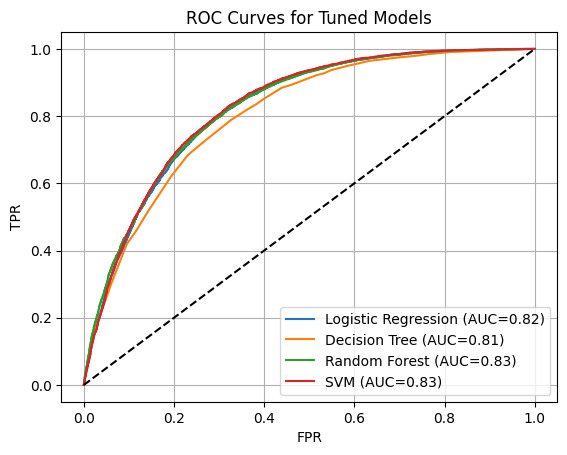

In [16]:
plt.figure()
for name, model in zip(["Logistic Regression", "Decision Tree", "Random Forest", "SVM"], [best_log, best_tree, best_rf, best_svm]):
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves for Tuned Models')
plt.legend()
plt.grid()
plt.show()

## Phase 4: Validation on Imbalanced Data

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
X_val = imbalanced_df.drop(columns='Diabetes_binary')
y_val = imbalanced_df['Diabetes_binary']

for name, model in zip(["Random Forest", "SVM"], [best_rf, best_svm]):
    print(f"\n--- {name}: the default threshold being (0.5) ---")

    val_preds = model.predict(X_val)
    print("confusion matrix:")
    print(confusion_matrix(y_val, val_preds))
    print("classification report:")
    print(classification_report(y_val, val_preds))

prevalence = y_val.mean()
print(f"\n the estimated prevalence in the imbalanced dataset: {prevalence:.4f}")

for name, model in zip(["Random Forest", "SVM"], [best_rf, best_svm]):
    val_probs = model.predict_proba(X_val)[:, 1]
    adjusted_preds = (val_probs > prevalence).astype(int)

    print(f"\n {name}: Adjusted Threshold (prevalence = {prevalence:.2f}) ---")
    print("confusion matrix:")
    print(confusion_matrix(y_val, adjusted_preds))
    print("classification report:")
    print(classification_report(y_val, adjusted_preds))



--- Random Forest: the default threshold being (0.5) ---
confusion matrix:
[[153727  64607]
 [  6553  28793]]
classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81    218334
         1.0       0.31      0.81      0.45     35346

    accuracy                           0.72    253680
   macro avg       0.63      0.76      0.63    253680
weighted avg       0.87      0.72      0.76    253680


--- SVM: the default threshold being (0.5) ---
confusion matrix:
[[149070  69264]
 [  6303  29043]]
classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80    218334
         1.0       0.30      0.82      0.43     35346

    accuracy                           0.70    253680
   macro avg       0.63      0.75      0.62    253680
weighted avg       0.87      0.70      0.75    253680


 the estimated prevalence in the imbalanced dataset: 0.1393

 Random Forest: Adjusted T

In [19]:
X_multi = multiclass_df.drop(columns='Diabetes_012')
y_multi = multiclass_df['Diabetes_012']

multi_model = RandomForestClassifier(n_estimators=100)
multi_model.fit(X_multi, y_multi)
multi_preds = multi_model.predict(X_multi)
print("\nMulticlass Classification Report (Random Forest)")
print(confusion_matrix(y_multi, multi_preds))
print(classification_report(y_multi, multi_preds))


Multiclass Classification Report (Random Forest)
[[213489     19    195]
 [   284   4323     24]
 [  1417     12  33917]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    213703
         1.0       0.99      0.93      0.96      4631
         2.0       0.99      0.96      0.98     35346

    accuracy                           0.99    253680
   macro avg       0.99      0.96      0.98    253680
weighted avg       0.99      0.99      0.99    253680

